In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from PIL import Image


import matplotlib.pyplot as plt
import numpy as np
import os

/Users/lukelorenz/opt/anaconda3/envs/deepLearn/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/lukelorenz/opt/anaconda3/envs/deepLearn/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE)
  Referenced from: '/Users/lukelorenz/opt/anaconda3/envs/deepLearn/lib/python3.10/site-packages/torchvision/image.so'
  Expected in: '/Users/lukelorenz/opt/anaconda3/envs/deepLearn/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'
  warn(f"Failed to load image Python extension: {e}")


In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()

)

torch.Size([819, 3, 256, 256])


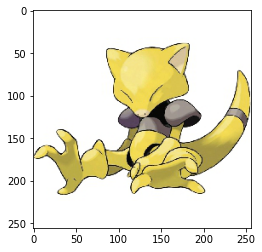

In [3]:
num_pokemon = len(os.listdir("data/pokemon_jpg/pokemon_jpg/"))

ims = []

transform = transforms.Compose([ #for converting images to tensor
    transforms.PILToTensor()
])

for im_name in os.listdir("data/pokemon_jpg/pokemon_jpg/"):
    s = (f"data/pokemon_jpg/pokemon_jpg/{str(im_name)}")
    curr = Image.open(s)
    currT = transform(curr)
    ims.append(currT)
    

ims = torch.stack(ims)

print(ims.shape)

#ims = ims[:,1,:,:]

#ims = ims/255 #normalizing

plt.imshow(transforms.ToPILImage()(ims[0]))
plt.savefig("./original.jpg")

In [4]:
ims[:100].shape

torch.Size([100, 3, 256, 256])

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
from torch.utils.data import DataLoader
dataloaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    'loader': torch.utils.data.DataLoader(ims, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}

In [7]:
loader = torch.utils.data.DataLoader(ims, batch_size=100, shuffle=True, num_workers=1),

In [8]:
#loader[0].size()

In [9]:
for images in loader:  
    print('Image batch dimensions:', images)

Image batch dimensions: <torch.utils.data.dataloader.DataLoader object at 0x7f783c64bfa0>


In [10]:
loader = dataloaders['loader']
for images in loader:  
    print('Image batch dimensions:', images.size())
    break

Image batch dimensions: torch.Size([100, 3, 256, 256])


In [11]:
##########################
### MODEL
##########################


class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :256, :256]


class VAE(nn.Module):
    def __init__(self):
        super(VAE,self).__init__()
        
        self.encoder = nn.Sequential(
                nn.Conv2d(3, 32, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.Flatten(),
        )
        
        #self.z_mean = torch.nn.Linear(2,2)
        self.z_mean = torch.nn.Linear(262144, 2)
        self.z_log_var = torch.nn.Linear(262144, 2)
        
        self.decoder = nn.Sequential(
                torch.nn.Linear(2, 262144),
                Reshape(-1, 64, 64, 64),
                nn.ConvTranspose2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),                
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 32, stride=(2, 2), kernel_size=(3, 3), padding=0),                
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(32, 3, stride=(1, 1), kernel_size=(3, 3), padding=0), 
                Trim(),  # 1x29x29 -> 1x28x28 #could be an issue
                nn.Sigmoid()
                )

    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded
        
    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1))
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z
        
    def forward(self, x):
        x = self.encoder(x)
        #print(x.shape)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

In [12]:
LEARNING_RATE = 0.0000005
BATCH_SIZE = 256
NUM_EPOCHS = 2

In [13]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
model = VAE()
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [20]:
num_epochs = 10
skip_epoch_stats = False
logging_interval=50


log_dict = {'train_combined_loss_per_batch': [],
                'train_combined_loss_per_epoch': [],
                'train_reconstruction_loss_per_batch': [],
                'train_kl_loss_per_batch': []}


loss_fn = F.mse_loss

for epoch in range(num_epochs):

    model.train()
    for batch_idx, (features) in enumerate(loader):
        

        features = features.to(DEVICE)
        features = features.float()

        # FORWARD AND BACK PROP
        encoded, z_mean, z_log_var, decoded = model(features)
        #print("model built")    
        # total loss = reconstruction loss + KL divergence
        #kl_divergence = (0.5 * (z_mean**2 + 
        #                        torch.exp(z_log_var) - z_log_var - 1)).sum()
        kl_div = -0.5 * torch.sum(1 + z_log_var 
                                      - z_mean**2 
                                      - torch.exp(z_log_var), 
                                      axis=1) # sum over latent dimension

        batchsize = kl_div.size(0)
        kl_div = kl_div.mean() # average over batch dimension
    
        pixelwise = loss_fn(decoded, features, reduction='none')
        pixelwise = pixelwise.view(batchsize, -1).sum(axis=1) # sum over pixels
        pixelwise = pixelwise.mean() # average over batch dimension
            
        loss = pixelwise + kl_div
            
        optimizer.zero_grad()
        #print("backward")
        loss.backward()

        # UPDATE MODEL PARAMETERS
        optimizer.step()
        #print("step")
        # LOGGING
        log_dict['train_combined_loss_per_batch'].append(loss.item())
        log_dict['train_reconstruction_loss_per_batch'].append(pixelwise.item())
        log_dict['train_kl_loss_per_batch'].append(kl_div.item())
            
       
        print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
                    % (epoch+1, num_epochs, batch_idx,
                        len(loader), loss))



Epoch: 001/010 | Batch 0000/0009 | Loss: 9806312448.0000
Epoch: 001/010 | Batch 0001/0009 | Loss: 9701757952.0000
Epoch: 001/010 | Batch 0002/0009 | Loss: 9798898688.0000
Epoch: 001/010 | Batch 0003/0009 | Loss: 9690364928.0000
Epoch: 001/010 | Batch 0004/0009 | Loss: 9725073408.0000
Epoch: 001/010 | Batch 0005/0009 | Loss: 9555379200.0000
Epoch: 001/010 | Batch 0006/0009 | Loss: 9571660800.0000
Epoch: 001/010 | Batch 0007/0009 | Loss: 9437316096.0000
Epoch: 001/010 | Batch 0008/0009 | Loss: 9647354880.0000
Epoch: 002/010 | Batch 0000/0009 | Loss: 9806761984.0000
Epoch: 002/010 | Batch 0001/0009 | Loss: 9582752768.0000
Epoch: 002/010 | Batch 0002/0009 | Loss: 9661379584.0000
Epoch: 002/010 | Batch 0003/0009 | Loss: 9472179200.0000
Epoch: 002/010 | Batch 0004/0009 | Loss: 9571786752.0000
Epoch: 002/010 | Batch 0005/0009 | Loss: 9490761728.0000
Epoch: 002/010 | Batch 0006/0009 | Loss: 9908990976.0000
Epoch: 002/010 | Batch 0007/0009 | Loss: 9841261568.0000
Epoch: 002/010 | Batch 0008/000

In [21]:
def plot_training_loss(minibatch_losses, num_epochs, averaging_iterations=100, custom_label=''):

    iter_per_epoch = len(minibatch_losses) // num_epochs

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(minibatch_losses)),
             (minibatch_losses), label=f'Minibatch Loss{custom_label}')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    if len(minibatch_losses) < 1000:
        num_losses = len(minibatch_losses) // 2
    else:
        num_losses = 1000

    ax1.set_ylim([
        0, np.max(minibatch_losses[num_losses:])*1.5
        ])

    ax1.plot(np.convolve(minibatch_losses,
                         np.ones(averaging_iterations,)/averaging_iterations,
                         mode='valid'),
             label=f'Running Average{custom_label}')
    ax1.legend()

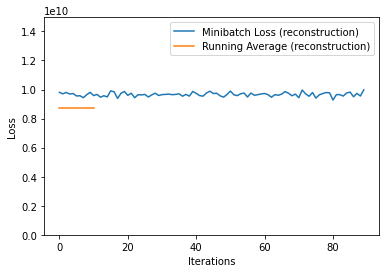

In [22]:
plot_training_loss(log_dict['train_reconstruction_loss_per_batch'], NUM_EPOCHS, custom_label=" (reconstruction)")
plt.show()

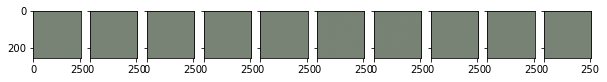

In [23]:
latent_size = 2
num_images = 10
unnormalizer = None

#giving noise
rand_features = torch.randn(num_images, latent_size)
new_images = model.decoder(rand_features)
color_channels = new_images.shape[1]
image_height = new_images.shape[2]
image_width = new_images.shape[3]


image_width = 28

fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(10, 2.5), sharey=True)
decoded_images = new_images[:num_images]

for ax, img in zip(axes, decoded_images):
    curr_img = img.detach()        

    if color_channels > 1:
        curr_img = np.transpose(curr_img, (1, 2, 0))
        ax.imshow(curr_img)
    else:
        ax.imshow(curr_img.view((image_height, image_width)), cmap='binary') 